In [101]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from pyramid.arima import auto_arima
from arch import arch_model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from pandas import DataFrame
import statsmodels.formula.api as smf

# Scouting tool for Defensive Players in Football

Team Members: Abhinav Katoch, Mayank

## Agenda

+ Developing a rating system for defensive players
+ Building a time series of player performance levels using rating system
+ Analyse the time series
+ Specific scouting use cases
+ Bayesian changepoint analysis

## Objective

+ Player metrics are usually reported in terms of counts or global averages. This ignores the distribution of those events.

+ By looking at a time series of these metrics we can obtain a better picture of player performance.

+ We want to identify players who are too inconsistent (low autocorrelation in time series), improving (upward trend) or any other interesting patterns.

+ We also want to compare moving averages of player scores to statistically relevant benchmarks for scouting.

# Data Description:

+ The data set we are using for this project is provided by Opta Pro

+ Contains event level information from all games from MLS Seasons 2011-2012 to 2018-19
+ We used data from MLS seasons 2015-16 to 2017-2018
+ During a season there are more than 35 games
+ Over 3 seasons many players have played more than 80 matches


# Methodology


## Building the rating system

+ Aggregating all games from 2015-16, 2016-17 and 2017-18 seasons
+ Identifying defensive actions from game events
    + Selected events are : 'fouls', 'tackles', 'interceptions', 'blocks', 'aerial_duels', 'cards', 'ball_recoveries', 'unsuccessful_challenges', 'errors'

+ Getting counts of each kind of defensive action performed by each player over the games played by that player
+ Using quadratic programming to get weights for our rating system
+ Developing a covariance matrix for all actions
+ Formulation of constraints for the optimization problem
+ Using the weights to get rating for each performance for each player


## Developing Time Series Model

+ Using the time series of each players performance match by match to identify the appropriate model for prediction of future player performance
+ Creating and identifying a model for each player 
    + Models used are ARIMA, SARIMAX, ARCH, GARCH
    
+ Addition of exogenous variables to improve the model accuracy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import os
from cvxopt import solvers, matrix
% matplotlib inline

In [3]:
os.chdir('/Users/abhinavkatoch/Downloads/Hackathon Raw Files/Full Datasets - Opta/MLS')
f_1718 = pd.read_csv('MLS 2017-2018.csv')
f_1617 = pd.read_csv('MLS 2016-2017.csv')
f_1516 = pd.read_csv('MLS 2015-2016.csv')
print(f_1718.shape, f_1617.shape, f_1516.shape)

/Users/abhinavkatoch/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (288,298) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/abhinavkatoch/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (226,288,298) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/abhinavkatoch/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (186,190,192,288) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(636393, 336) (576196, 336) (579528, 336)


Concatenating all the data frames in one data frame for analysis

In [4]:
f_1718["year"] = "17_18"
f_1617["year"] = "16_17"
f_1516["year"] = "15_16"

In [5]:
f = f_1718.append([f_1617, f_1516])

In [6]:
f.shape

(1792117, 337)

In [7]:
events = [1, 4, 7, 8, 
           10, 12,15, 
          16, 17,44,45, 
          49, 50, 51, 55, 
          56, 61, 74]
f2 = f.loc[f['event_type_id'].isin(events)]
f2 = f2.loc[f2.groupby("player_id")["game_id"].transform("count")>50]

In [8]:
len(f2)

1509534

In [9]:
g = f2[['player_id', 'event_type_id']]

In [10]:
g2 = g.groupby(['player_id', 'event_type_id']).size().to_frame(name = 'count').reset_index()

In [11]:
df = g2.pivot(index = 'player_id', columns = 'event_type_id', values = 'count')

In [12]:
col_names = ['passes', 'fouls', 'tackles', 'interceptions',
            'saves', 'clearances', 'blocks', 
             'goals','cards', 'aerial_duels','unsuccessful_challenges',
             'ball_recoveries','dispossessed', 'errors', 'offsides_provoked',
             'shield_out_of_plays','bad_touch', 'blocked_pass']

In [13]:
df.columns = col_names

In [14]:
df.head()

,passes,fouls,tackles,interceptions,saves,clearances,blocks,goals,cards,aerial_duels,unsuccessful_challenges,ball_recoveries,dispossessed,errors,offsides_provoked,shield_out_of_plays,bad_touch,blocked_pass
player_id,,,,,,,,,,,,,,,,,,
1212.0,202.0,22.0,14.0,4.0,NaN,6.0,8.0,1.0,1.0,14.0,3.0,33.0,10.0,NaN,NaN,NaN,20.0,6.0
1710.0,1042.0,65.0,9.0,4.0,NaN,3.0,52.0,30.0,2.0,29.0,4.0,95.0,56.0,NaN,NaN,NaN,67.0,10.0
1814.0,1700.0,64.0,46.0,52.0,14.0,38.0,32.0,6.0,2.0,39.0,21.0,161.0,28.0,NaN,1.0,NaN,56.0,16.0
2051.0,1020.0,59.0,20.0,17.0,3.0,19.0,29.0,15.0,4.0,22.0,6.0,97.0,35.0,NaN,NaN,NaN,51.0,13.0
3740.0,1192.0,85.0,34.0,61.0,3.0,71.0,7.0,NaN,7.0,63.0,6.0,107.0,11.0,NaN,6.0,3.0,55.0,12.0


In [15]:
df.mean(axis = 0)

passes                     1294.163291
fouls                        68.439336
tackles                      52.584535
interceptions                48.683246
saves                        20.252322
clearances                   62.653141
blocks                       20.077273
goals                         6.406883
cards                         6.206897
aerial_duels                 70.442602
unsuccessful_challenges      20.275676
ball_recoveries             138.111534
dispossessed                 34.041783
errors                        1.950617
offsides_provoked            11.217722
shield_out_of_plays           2.360784
bad_touch                    63.540541
blocked_pass                 22.519444
dtype: float64

In [16]:
df.var(axis = 0)

passes                     1.530612e+06
fouls                      5.035924e+03
tackles                    3.047254e+03
interceptions              3.474720e+03
saves                      2.000270e+03
clearances                 7.413367e+03
blocks                     7.819470e+02
goals                      7.936555e+01
cards                      2.887905e+01
aerial_duels               6.679098e+03
unsuccessful_challenges    4.664138e+02
ball_recoveries            1.938097e+04
dispossessed               1.752966e+03
errors                     2.121518e+00
offsides_provoked          2.160946e+02
shield_out_of_plays        5.648850e+00
bad_touch                  4.423522e+03
blocked_pass               4.881053e+02
dtype: float64

In [17]:
col_subset = ['fouls','tackles', 'interceptions', 'blocks', 'aerial_duels', 
              'cards', 'ball_recoveries','unsuccessful_challenges', 'errors']

In [18]:
df.columns = col_names

In [19]:
df_ = df[col_subset]

In [20]:
df_.fillna(value = 0, inplace = True)

/Users/abhinavkatoch/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [21]:
df_ = (df_ - df_.mean(axis = 0))/(2* df_.std(axis = 0))

In [22]:
r_avg = df_.mean(axis = 0)

Segregating negative events to change their sign values and use in the quadratic programming algorithm

In [23]:
neg_events = ['fouls', 'cards', 'unsuccessful_challenges', 'dispossessed', 'errors', 'bad_touch']

In [24]:
reduced_set = ['fouls', 'errors', 'cards']

In [25]:
for col in reduced_set:
    df_[col] = -1*df_[col]

# Quadratic Programming

$$
\begin{aligned}
minimize:   w^T \Sigma w  \\
st:   w^T x \ge 0 \\
 \Sigma_{1}^{n}w_i = 1 \\
\end{aligned}
$$

the parameters are defined as follows:
+ w is the weight matrix we want to solve for
+ $\Sigma$ is the covariance matrix used to define the quadratic objective function
+ r_avg is the average count for each kind of event


We used CVXOPT to solve the optimization problem.

The analogy we are working with is that each defensive trait is like a stock and each player is like a portfolio of those stocks. How much weight should we give to each trait when building our portfolio?

A Portfolio Optimization Problem:

$$
\begin{aligned}
minimize:   x^T P x + q^T x  \\
st:   Gx \le h \\
 Ax = B \\
\end{aligned}
$$

where:

+ P = our covariance matrix $\Sigma$
+ Q = a matrix of zeros
+ $ Gx \le h $ captures our inequality constraints
+ $ \Sigma_{1}^{n}w_i $ is caputed by Ax = B


In [26]:
sigma = df_.cov()

In [27]:
sigma = matrix(np.array(sigma))

In [28]:
r_avg = matrix(np.array(r_avg))

In [29]:
r_min = 0.0

In [30]:
P = sigma

In [31]:
n = len(df_.columns)

In [32]:
q = matrix(np.zeros((n,1)))

In [33]:
G = matrix(np.concatenate((-np.transpose(np.array(r_avg)), -np.identity(n)), 0))

In [34]:
h = matrix(np.concatenate((-np.ones((1,1))*r_min,np.zeros((n,1))),0))

In [35]:
A = matrix(1.0, (1,n))

In [36]:
B = matrix(1.0)

In [37]:
sol = solvers.qp(P, q, G, h, A, B)

     pcost       dcost       gap    pres   dres
 0:  7.4920e-03 -1.0371e+00  1e+01  3e+00  3e+00
 1:  1.0949e-02 -8.3887e-01  9e-01  3e-02  3e-02
 2:  8.6765e-03 -5.2770e-02  6e-02  2e-03  2e-03
 3:  4.1040e-03 -3.3491e-03  7e-03  4e-05  4e-05
 4:  3.5478e-03  2.7104e-03  8e-04  2e-06  2e-06
 5:  3.4554e-03  3.3881e-03  7e-05  3e-08  3e-08
 6:  3.4445e-03  3.4397e-03  5e-06  3e-10  3e-10
 7:  3.4433e-03  3.4427e-03  5e-07  3e-12  3e-12
 8:  3.4431e-03  3.4431e-03  6e-08  3e-14  3e-14
Optimal solution found.


In [38]:
list(df_.columns)

['fouls',
 'tackles',
 'interceptions',
 'blocks',
 'aerial_duels',
 'cards',
 'ball_recoveries',
 'unsuccessful_challenges',
 'errors']

In [39]:
list(sol['x'])

[0.37390792650005966,
 0.08446842864164125,
 0.0027633121770347193,
 0.16621568655970087,
 0.08669972945483455,
 0.048711106007918135,
 0.14240669651231017,
 0.04331360397344291,
 0.051513510173057844]

In [40]:
df_.std()

fouls                      0.5
tackles                    0.5
interceptions              0.5
blocks                     0.5
aerial_duels               0.5
cards                      0.5
ball_recoveries            0.5
unsuccessful_challenges    0.5
errors                     0.5
dtype: float64

Writing this to csv

In [41]:
weights = list(sol['x'])

In [42]:
import pickle
pickle.dump( weights, open( "weights.p", "wb" ) )

# Data Preparation for time series modeling

Since the data set we had was huge, we segregated a set of 30 players in order to analyze the time series models and to create a POC project 

The steps involved in data filteration are as follows:
+ We utilized the weights we obtained from the quadratic programming and calculated the in match performance of each player
+ We then selected players who had played more than 80 matched during the 3 seasons
+ Then out of the segregaated number of players (>90) we created 3 classes of players, viz. High performing players, Medium level players, Low performing players
+ For, the purpose of creating a POC, we selected 10 players from each class
+ We build 30 different time series models for these players to predict their performances in the future so as to use it as a scouting help
+ In this presentation, we are showing the use cases and evaluation for 7 players

In [43]:
df2 = df[col_subset]
df2.fillna(value = 0, inplace = True)

/Users/abhinavkatoch/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [44]:
scoresdf = df2.multiply(weights).sum(axis = 1).to_frame(name = 'score')

In [45]:
f2 = f.loc[f['event_type_id'].isin(events)]
h = f2[['player_id', 'game_id', 'event_type_id']]

In [46]:
h2 = h.groupby(['player_id','game_id' ,'event_type_id']).size().to_frame(name = 'count').reset_index()

In [47]:
season_vals = h2.set_index(['player_id', 'game_id', 'event_type_id']).unstack(level = -1)

In [48]:
season_vals.fillna(value = 0, inplace = True)

In [49]:
season_vals.head()

count                                                    \
event_type_id        1    4    7    8    10   12   15   16   17   44   45   
player_id game_id                                                           
1212.0    791414   20.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0   
          791591   10.0  3.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0   
          791597   10.0  2.0  2.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
          791607   10.0  2.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
          791614    6.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   

                                                      
event_type_id       49   50   51   55   56   61   74  
player_id game_id                                     
1212.0    791414   3.0  2.0  0.0  0.0  0.0  1.0  0.0  
          791591   3.0  0.0  0.0  0.0  0.0  2.0  2.0  
          791597   2.0  1.0  0.0  0.0  0.0  0.0  1.0  
          791607   3.0  0.0  0.0  0.0  0.0  0.0  0.0  
          791614   1.0  0.0  0.0  0.0  0.0  1.0  0.0

In [50]:
season_vals.columns = col_names

In [51]:
season_vals = season_vals[col_subset]

In [52]:
season_scores = season_vals.multiply(weights).sum(axis = 1).to_frame(name = 'score')

In [53]:
season_scores.head()

score
player_id game_id          
1212.0    791414   1.140743
          791591   1.548944
          791597   1.380291
          791607   1.425720
          791614   0.393091

In [192]:
with open ('scores.p', 'rb') as fp:
    scores = pickle.load(fp)

In [193]:
newlist = [item for items in list(scores.values()) for item in items]
newlist = sorted(newlist)
mean_score = np.mean(newlist)

In [194]:
median_score = np.percentile(newlist, 50)
score_75 = np.percentile(newlist, 75)
score_90 = np.percentile(newlist, 90)
score_99 = np.percentile(newlist, 99)

In [195]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns

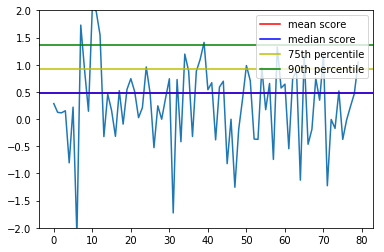

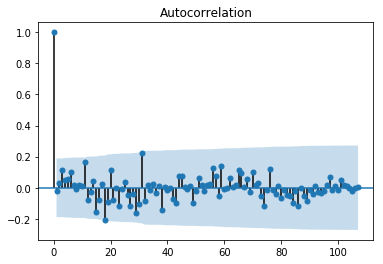

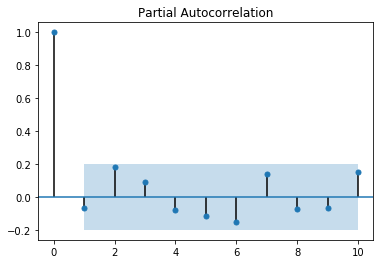

/Users/abhinavkatoch/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


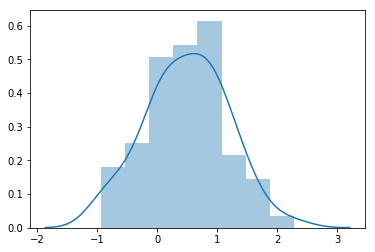

In [196]:
plt.figure(figsize = (6,4))
#plt.subplots(nrows = 2, ncols = 2)
#plt.hist(scores[np.random.choice(list(scores.keys()))])
plt.plot(scores[np.random.choice(list(scores.keys()))])
plt.axhline(y=mean_score, color='r', linestyle='-', label = 'mean score')
plt.axhline(y=median_score, color='b', linestyle='-', label = 'median score')
plt.axhline(y=score_75, color='y', linestyle='-', label = '75th percentile')
plt.axhline(y=score_90, color='g', linestyle='-', label = '90th percentile')
#plt.axhline(y=score_99, color='y', linestyle='-', label = '99th percentile')
plt.legend(loc = 'upper right')
plt.ylim((-2,2))
plot_acf(scores[np.random.choice(list(scores.keys()))])
plot_pacf(scores[np.random.choice(list(scores.keys()))], lags=10)
plt.show()
sns.distplot(scores[np.random.choice(list(scores.keys()))])

In [197]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [198]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

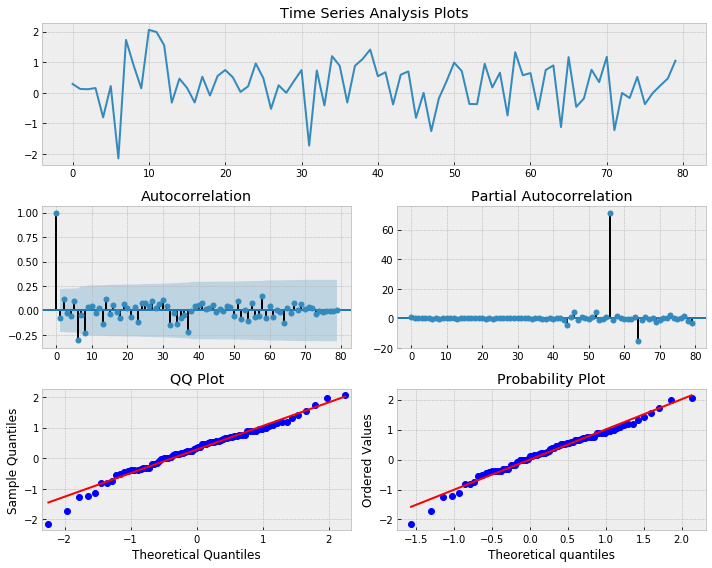

In [199]:
y = scores[np.random.choice(list(scores.keys()))]
y2 = np.power(y,2)
tsplot(y)

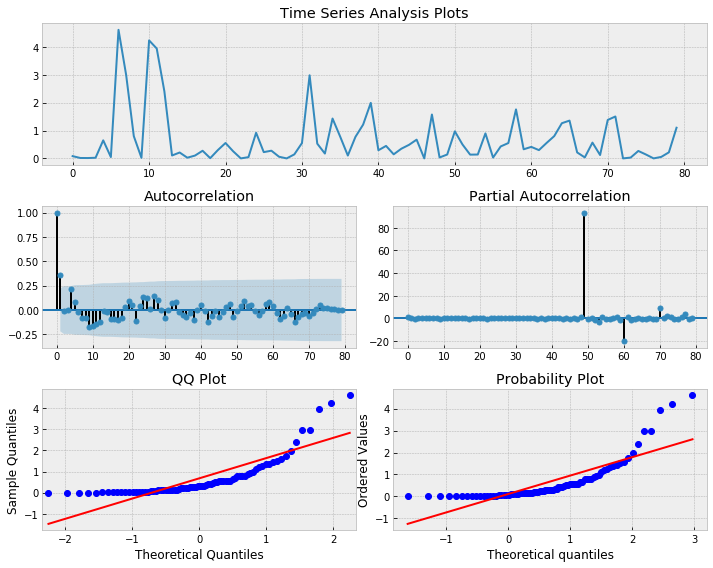

In [200]:
tsplot(y2)

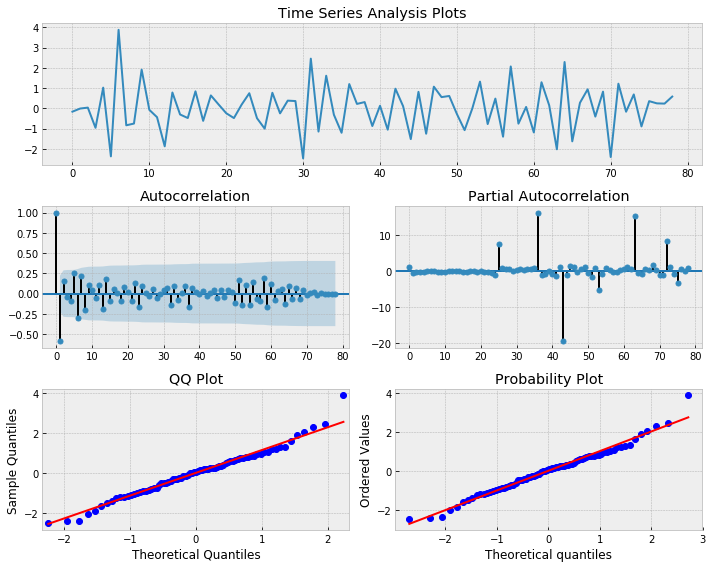

In [201]:
tsplot(difference(y))

In [202]:

stepwise_model = auto_arima(y, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=189.618, BIC=200.641, Fit time=0.411 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=245.122, BIC=249.531, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=212.929, BIC=221.748, Fit time=0.082 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=187.871, BIC=196.689, Fit time=0.339 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=189.865, BIC=200.889, Fit time=0.592 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=205.534, BIC=212.149, Fit time=0.130 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=222.521, BIC=229.135, Fit time=0.197 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=189.6

In [203]:
model = ARIMA(y, order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   79
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -94.078
Method:                       css-mle   S.D. of innovations              0.774
Date:                Thu, 23 Aug 2018   AIC                            194.156
Time:                        15:18:05   BIC                            201.264
Sample:                             1   HQIC                           197.004
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.004     -0.560      0.577      -0.009       0.005
ma.L1.D.y     -1.0000      0.034    -29.420      0.000      -1.067      -0.933
                                    Roots           

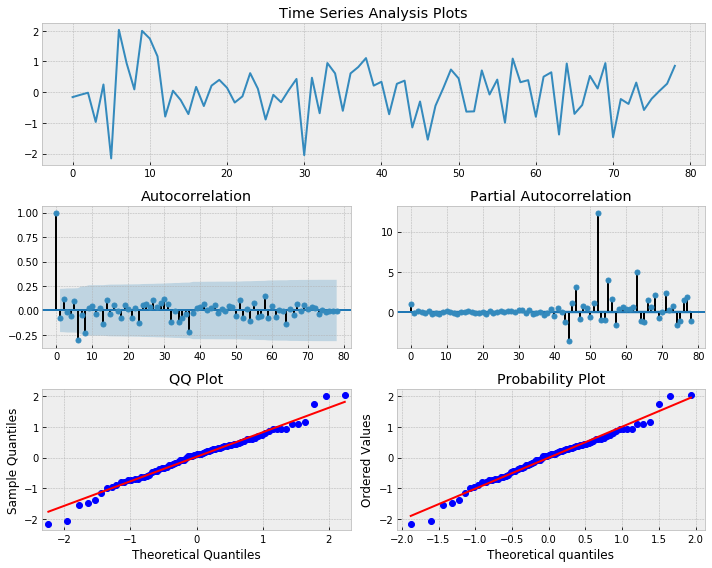

In [204]:
tsplot(model_fit.resid)

In [205]:
model = SARIMAX(y, order=(1,1,1), seasonal_order=(0, 1, 1, 12), enforce_invertibility = False)
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   80
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -89.792
Date:                            Thu, 23 Aug 2018   AIC                            187.584
Time:                                    15:18:06   BIC                            196.403
Sample:                                         0   HQIC                           191.074
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0581      0.134      0.432      0.666      -0.206       0.322
ma.L1         -1.0000   1301.262   

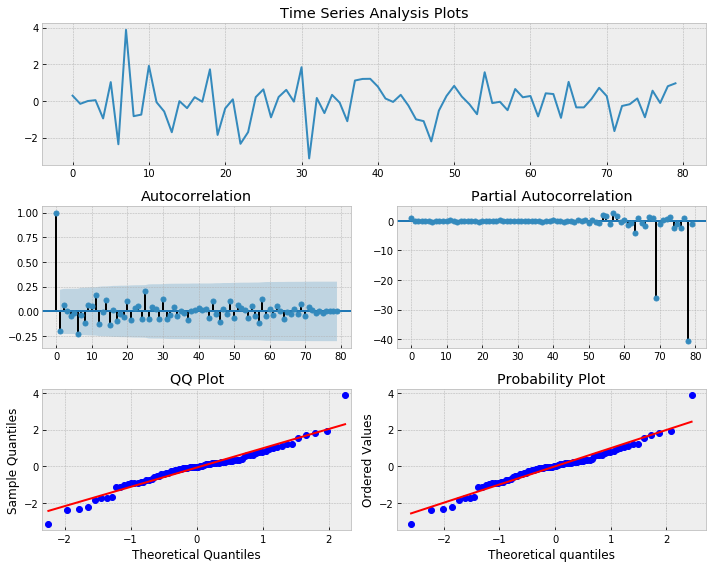

In [206]:
tsplot(model_fit.resid)

In [207]:
am = arch_model(y, vol = 'GARCH', p=2, o = 1, q=2, dist = 't')
res = am.fit(update_freq = 5)
print(res.summary())

Iteration:      5,   Func. Count:     56,   Neg. LLF: 91.53300971624608
Iteration:     10,   Func. Count:    106,   Neg. LLF: 91.48863790247921
Iteration:     15,   Func. Count:    160,   Neg. LLF: 91.48282312287319
Iteration:     20,   Func. Count:    214,   Neg. LLF: 91.48183205118977
Iteration:     25,   Func. Count:    264,   Neg. LLF: 91.47341087711368
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 91.47340873027716
            Iterations: 27
            Function evaluations: 276
            Gradient evaluations: 26
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -91.4734
Distribution:      Standardized Student's t   AIC:                           198.947
Meth

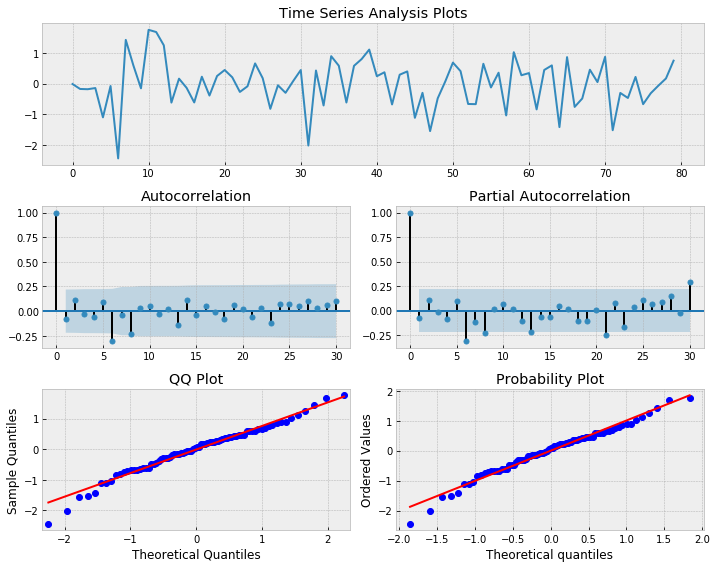

In [208]:
tsplot(res.resid, lags = 30)

In [209]:
with open ('game_date.dms', 'rb') as fp:
    game_date = pickle.load(fp)

In [210]:
with open ('list_of_30_players', 'rb') as fp:
    player_list = pickle.load(fp)

In [211]:
game_date['game_date'] = pd.to_datetime(game_date['game_date']).dt.date
#game_date.drop_duplicates()

In [212]:
game_date.head()

,game_id,game_date
0,957466,2017-12-09
1698,957465,2017-12-01
3330,956453,2017-11-30
5034,956452,2017-11-22
6702,956451,2017-11-22


In [213]:
len(game_date)

1236

In [214]:
season_vals = season_vals.reset_index(level = 0, drop = False)
#season_vals = season_vals.reset_index(level = 0, drop = False)
len(season_vals)

30418

Segregating players which are there in my player list

In [215]:
season_vals1 = season_vals.loc[season_vals['player_id'].isin(player_list)]
print(len(season_vals1), season_vals1.head())

2530      game_id  player_id  fouls  tackles  interceptions  blocks  aerial_duels  \
565   788520    12780.0    2.0      1.0            5.0     0.0           1.0   
566   791393    12780.0    2.0      2.0            1.0     1.0           1.0   
567   791406    12780.0    1.0      3.0            1.0     0.0           0.0   
568   791412    12780.0    3.0      5.0            3.0     0.0           2.0   
569   791428    12780.0    1.0      2.0            0.0     0.0           1.0   

     cards  ball_recoveries  unsuccessful_challenges  errors  
565    0.0              2.0                      1.0     0.0  
566    0.0              3.0                      0.0     0.0  
567    0.0              5.0                      0.0     0.0  
568    0.0              4.0                      0.0     0.0  
569    0.0              5.0                      0.0     0.0  


In [216]:
season_vals1 = season_vals1.reset_index(level = 0, drop = False)

In [217]:
sv = season_vals1.merge(game_date, on = 'game_id')


In [218]:
import datetime as dt

In [219]:
diffsv = sv.sort_values(by = 'game_date', ascending = False).groupby(['player_id']).apply(lambda x: x['game_date'] - x['game_date'].shift(-1)).to_frame(name = 'diff')

In [220]:
diffsv['diff'] = diffsv['diff'].fillna(value = 4).astype('timedelta64[D]')
diffsv.head()

diff
player_id          
12780.0   274   0.0
          273  23.0
          253   0.0
          254  13.0
          259   5.0

In [221]:
#diffsv['diff'] = diffsv['diff'].dt.days
#diffsv.head()

In [222]:
diffsv.values

array([[ 0.],
       [23.],
       [ 0.],
       ...,
       [ 8.],
       [ 7.],
       [ 0.]])

In [223]:
import pickle
pickle.dump( diffsv, open( "diff.p", "wb" ) )

# Adding exogenous variables to the score data set and subsetting the number of players to the list of 30 I have created

In [224]:
with open ('list_of_30_players', 'rb') as fp:
    player_list = pickle.load(fp)
player_list

array([ 37368.,  41626.,  41552., 151940.,  83065.,  42584., 153264.,
       111114.,  60207.,  86035.,  59848.,  41703.,  44209.,  60152.,
        50122.,  56394.,  94368., 110974., 117549.,  41551., 129430.,
       193906.,  94934., 121332., 197428.,  15310.,  33823.,  41606.,
        82519.,  12780.])

In [225]:
with open ('home_game_flag', 'rb') as fp:
    home_flag = pickle.load(fp)
home_flag.head()

,team_id,player_id,game_id,home_team,home_flag
0,3500,NaN,957466,2077,0
1,2077,NaN,957466,2077,1
2,3500,20226.0,957466,2077,0
3,3500,34160.0,957466,2077,0
4,2077,68259.0,957466,2077,1


## subsetting the list of players

scores file contains a dictionary with player ids and their respective scores, this part is there is ts_soccer_model notebook

Merging with the player_id and game_id to get the home_flag in this data set

In [226]:
exo_data = home_flag.loc[home_flag['player_id'].isin(player_list)]
print(len(exo_data))
exo_data = exo_data.sort_values(['player_id', 'game_id'], ascending=[True, True])
exo_data.head()

2530


,team_id,player_id,game_id,home_team,home_flag
563123,3500,12780.0,788520,3500,1
541604,3500,12780.0,791393,3500,1
522870,3500,12780.0,791406,1903,0
512963,3500,12780.0,791412,3500,1
486468,3500,12780.0,791428,1230,0


In [227]:
# no player is being lost
len(exo_data["player_id"].drop_duplicates())

30

## Forecasting Player Performance With Linear Time Series Models

## ARIMA Model

In [228]:
n = np.random.choice(list(scores.keys()))
print(n)

153264.0


In [229]:
y1 = scores[n]
print(len(y1))

85


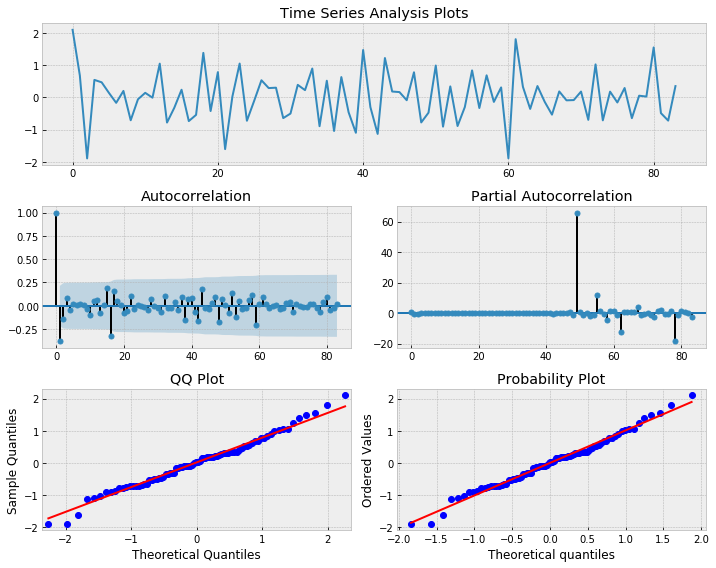

In [230]:
tsplot(difference(y1))

In [231]:
#e1 = exo_data.home_flag(exo_data["player_id"]==33808.0)
e1 = exo_data["home_flag"].loc[exo_data['player_id'] == n]
print(len(e1))
e2 = e1[1:]

85


In [232]:
diffs = diffsv.loc[n , :]
diffs2 = list(diffs['diff'].values)[0: len(y1) - 1]
diffs = list(diffs['diff'].values)[0: len(y1)]
len(diffs)

85

In [233]:
stepwise_model = auto_arima(y1, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=157.284, BIC=167.007, Fit time=0.123 seconds
Fit ARIMA: order=(0, 1, 0); AIC=198.202, BIC=203.064, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=185.947, BIC=193.240, Fit time=0.015 seconds
Fit ARIMA: order=(0, 1, 1); AIC=155.817, BIC=163.110, Fit time=0.053 seconds
Fit ARIMA: order=(0, 1, 2); AIC=157.174, BIC=166.897, Fit time=0.084 seconds
Fit ARIMA: order=(1, 1, 2); AIC=156.520, BIC=168.675, Fit time=0.167 seconds
Total fit time: 0.446 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   84
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -74.909
Method:                       css-mle   S.D. of innovations              0.575
Date:                Thu, 23 Aug 2018   AIC                            155.817
Time:                        15:18:08   BIC                            163.110
Sample:                           

In [234]:
modelx = ARIMA(y1, order=(0,1,1))#, exog= e1)
model_fit = modelx.fit(disp=0)
print(model_fit.summary())
# plot residual errors

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   84
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -74.909
Method:                       css-mle   S.D. of innovations              0.575
Date:                Thu, 23 Aug 2018   AIC                            155.817
Time:                        15:18:08   BIC                            163.110
Sample:                             1   HQIC                           158.749
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -1.043      0.300      -0.008       0.002
ma.L1.D.y     -1.0000      0.042    -23.893      0.000      -1.082      -0.918
                                    Roots           

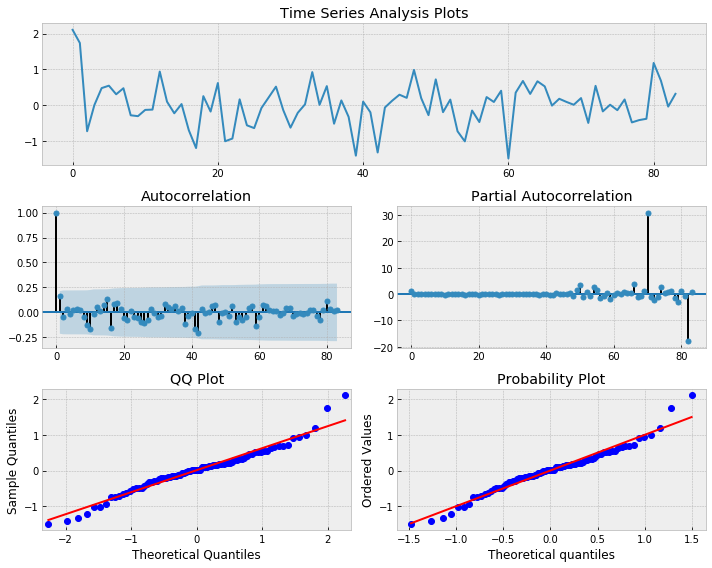

In [235]:
tsplot(model_fit.resid)

## Adding Exogenous Variable 1: Home or Away Game Flag

In this part we will first fit the exogenous variables with a linear (OLS) model and then fit a linear time series model on the OLS residuals.

In [236]:
d = pd.DataFrame(y1, e1)
d.reset_index(level = 0, inplace = True)

d.columns = ['scores', 'homeaway']

lm = smf.ols(formula = 'scores ~ homeaway', data=d)

res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8209
Date:                Thu, 23 Aug 2018   Prob (F-statistic):              0.368
Time:                        15:18:09   Log-Likelihood:                -61.221
No. Observations:                  85   AIC:                             126.4
Df Residuals:                      83   BIC:                             131.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5759      0.084      6.831      0.0

### Fitting the residuals to a linear time series

In [237]:
modelx = ARIMA(res.resid, order=(2,1,2))#, exog= e1)
model_fit = modelx.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   84
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -56.486
Method:                       css-mle   S.D. of innovations              0.458
Date:                Thu, 23 Aug 2018   AIC                            124.972
Time:                        15:18:09   BIC                            139.557
Sample:                             1   HQIC                           130.835
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.929e-05      0.001      0.049      0.961      -0.002       0.002
ar.L1.D.y     -0.1875      0.418     -0.448      0.655      -1.007       0.632
ar.L2.D.y     -0.1284      0.189     -0.678      0.5

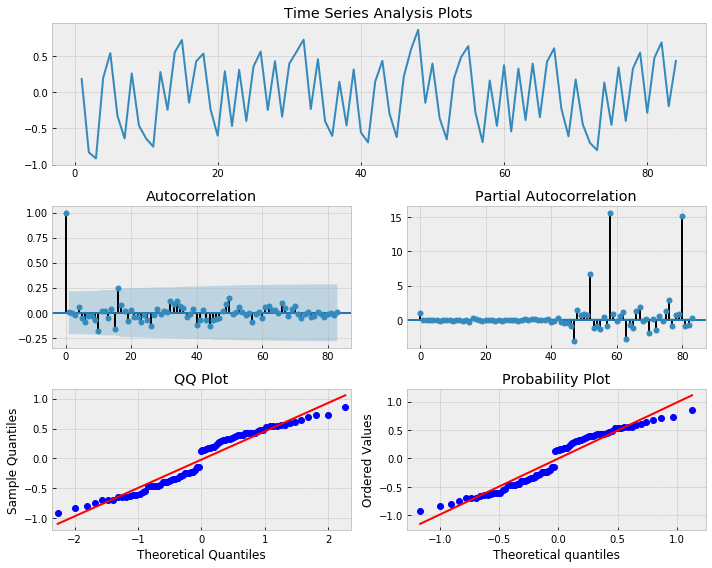

In [238]:
tsplot(model_fit.resid)

## Adding Exogenous Variable 2: Number of rest days between games

In [239]:
d['restdays'] = diffs
lm = smf.ols(formula = 'scores ~ homeaway + restdays', data=d)

res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.4055
Date:                Thu, 23 Aug 2018   Prob (F-statistic):              0.668
Time:                        15:18:09   Log-Likelihood:                -61.221
No. Observations:                  85   AIC:                             128.4
Df Residuals:                      82   BIC:                             135.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5759      0.090      6.423      0.0

In [240]:
res.resid = res.resid.dropna()
modelx = ARIMA(res.resid, order=(1,1,1))#, exog= e1)
model_fit = modelx.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -58.284
Method:                       css-mle   S.D. of innovations              0.470
Date:                Thu, 23 Aug 2018   AIC                            124.568
Time:                        15:18:09   BIC                            134.292
Sample:                             1   HQIC                           128.477
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.27e-05      0.002     -0.027      0.978      -0.003       0.003
ar.L1.D.y     -0.3352      0.103     -3.255      0.002      -0.537      -0.133
ma.L1.D.y     -1.0000      0.031    -31.770      0.0

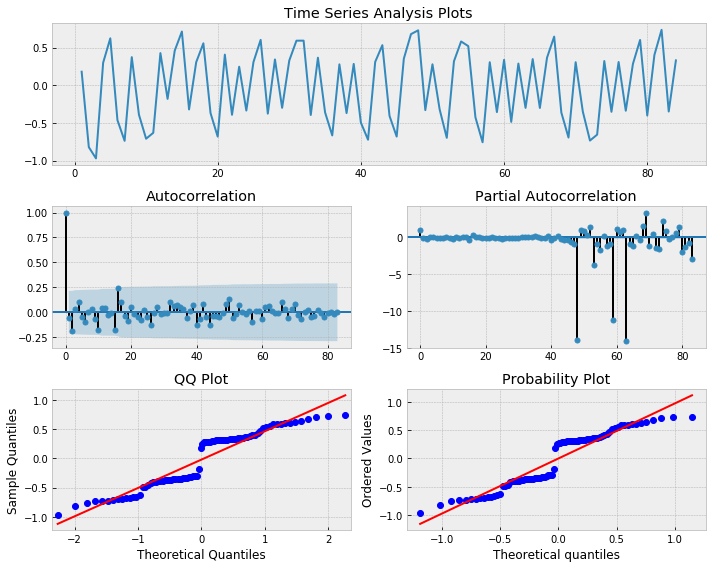

In [241]:
tsplot(model_fit.resid)

## Testing SARIMA model

In [242]:
modelx = SARIMAX(y1, order=(0,1,1), seasonal_order=(0, 1, 1, 12))#, exog=e1)
model_fit = modelx.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -79.120
Date:                            Thu, 23 Aug 2018   AIC                            164.239
Time:                                    15:18:10   BIC                            171.069
Sample:                                         0   HQIC                           166.958
                                             - 85                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9598      0.147     -6.540      0.000      -1.247      -0.672
ma.S.L12      -0.9872      3.323   

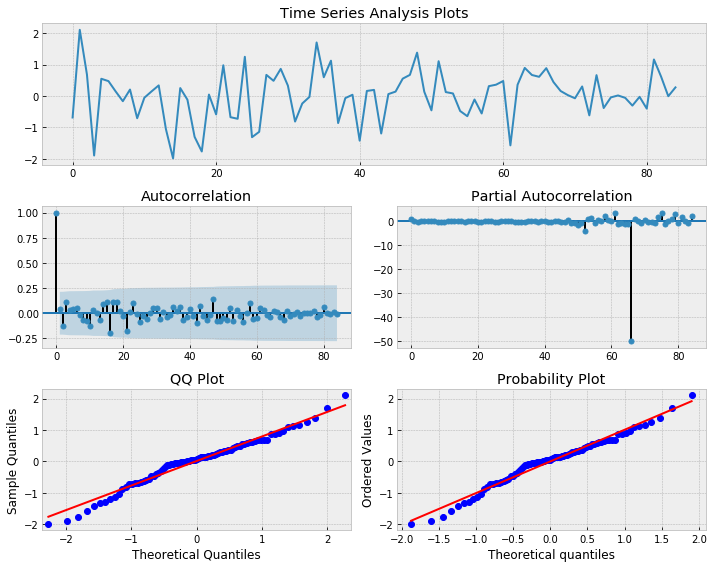

In [243]:
tsplot(model_fit.resid)

## Adding Exogenous Variable 1: Home/Away Flag

In [244]:
d = pd.DataFrame(y1, e1)
d.reset_index(level = 0, inplace = True)

d.columns = ['scores', 'homeaway']

lm = smf.ols(formula = 'scores ~ homeaway', data=d)

res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8209
Date:                Thu, 23 Aug 2018   Prob (F-statistic):              0.368
Time:                        15:18:11   Log-Likelihood:                -61.221
No. Observations:                  85   AIC:                             126.4
Df Residuals:                      83   BIC:                             131.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5759      0.084      6.831      0.0

In [246]:
modelx = SARIMAX(res.resid, order=(1,1,1), seasonal_order=(0, 1, 1, 12))#, exog=e1)
model_fit = modelx.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -61.594
Date:                            Thu, 23 Aug 2018   AIC                            131.189
Time:                                    15:18:30   BIC                            140.296
Sample:                                         0   HQIC                           134.814
                                             - 85                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3368      0.125     -2.691      0.007      -0.582      -0.091
ma.L1         -0.9981      2.873   

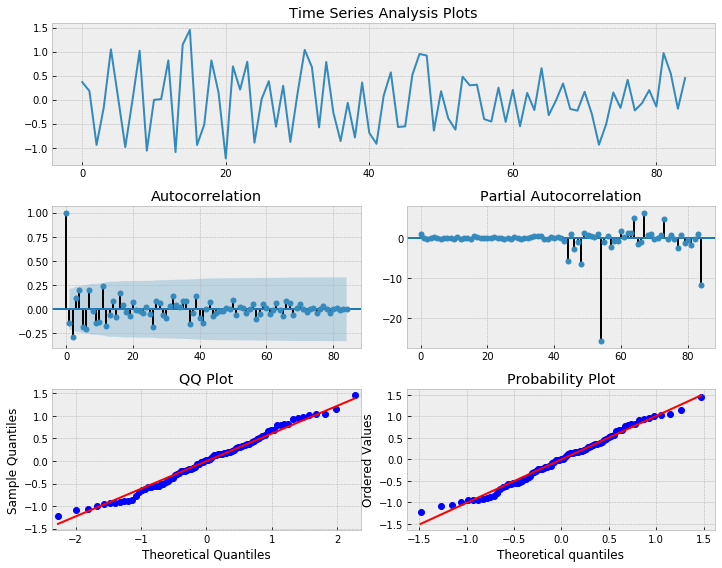

In [247]:
tsplot(model_fit.resid)

## Adding Exogenous Variable 2: Rest Days

In [248]:
d['restdays'] = diffs

#d.columns = ['homeaway', 'scoreresiduals', 'restdays']

lm = smf.ols(formula = 'scores ~ homeaway + restdays', data=d)

res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.4055
Date:                Thu, 23 Aug 2018   Prob (F-statistic):              0.668
Time:                        15:18:35   Log-Likelihood:                -61.221
No. Observations:                  85   AIC:                             128.4
Df Residuals:                      82   BIC:                             135.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5759      0.090      6.423      0.0

In [250]:
modelx = SARIMAX(res.resid, order=(1,1,1), seasonal_order=(0, 1, 1, 12))#, exog=e1)
model_fit = modelx.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   85
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -61.597
Date:                            Thu, 23 Aug 2018   AIC                            131.193
Time:                                    15:18:45   BIC                            140.300
Sample:                                         0   HQIC                           134.818
                                             - 85                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3373      0.125     -2.694      0.007      -0.583      -0.092
ma.L1         -0.9984      3.259   

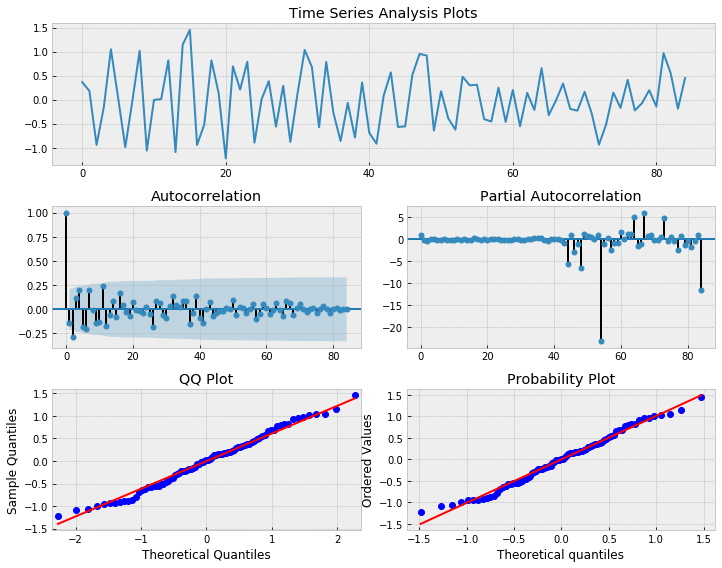

In [251]:
tsplot(model_fit.resid)

## GARCH model

In [252]:
amx = arch_model(y1, vol = 'GARCH', p=1, o = 1, q=1, dist = 'Normal')
res = amx.fit(update_freq = 5)
print(res.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 72.67927911279214
Iteration:     10,   Func. Count:     87,   Neg. LLF: 72.31342315670804
Iteration:     15,   Func. Count:    122,   Neg. LLF: 72.25378814171415
Iteration:     20,   Func. Count:    157,   Neg. LLF: 72.24238300197601
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 72.24238161812201
            Iterations: 21
            Function evaluations: 164
            Gradient evaluations: 21
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -72.2424
Distribution:                  Normal   AIC:                           154.485
Method:            Maximum Likelihood   BIC:                           166.698
                           

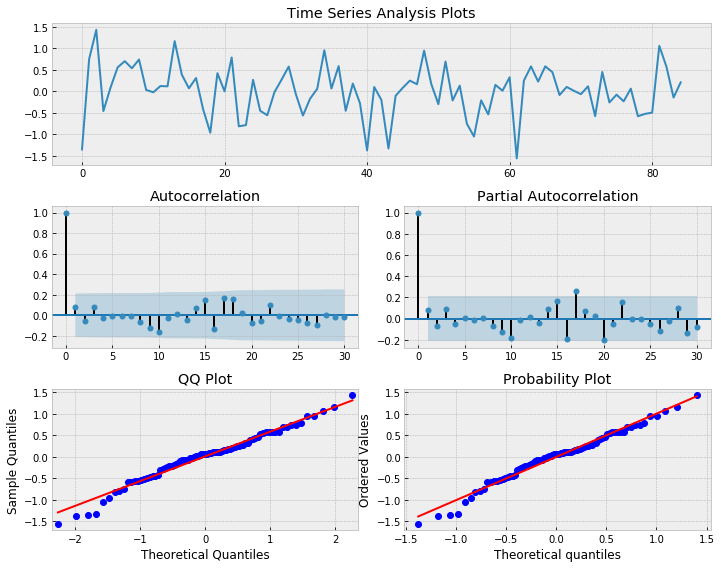

In [253]:
tsplot(res.resid, lags = 30)

## Adding Exogenous Variable 1: Home/Away Flag

In [254]:
d = pd.DataFrame(y1, e1)
d.reset_index(level = 0, inplace = True)

d.columns = ['scores', 'homeaway']

lm = smf.ols(formula = 'scores ~ homeaway', data=d)

res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8209
Date:                Thu, 23 Aug 2018   Prob (F-statistic):              0.368
Time:                        15:18:50   Log-Likelihood:                -61.221
No. Observations:                  85   AIC:                             126.4
Df Residuals:                      83   BIC:                             131.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5759      0.084      6.831      0.0

In [255]:
amx = arch_model(res.resid**2, vol = 'GARCH', p=1, o = 1, q=1, dist = 'Normal')
res = amx.fit(update_freq = 5)
print(res.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: -130.72085571860453
Iteration:     10,   Func. Count:     83,   Neg. LLF: -130.89910679681967
Iteration:     15,   Func. Count:    118,   Neg. LLF: -130.9260068224524
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -130.92601205576676
            Iterations: 16
            Function evaluations: 125
            Gradient evaluations: 16
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                130.926
Distribution:                  Normal   AIC:                          -251.852
Method:            Maximum Likelihood   BIC:                          -239.639
                                        No. Observations:                   85
Date:        

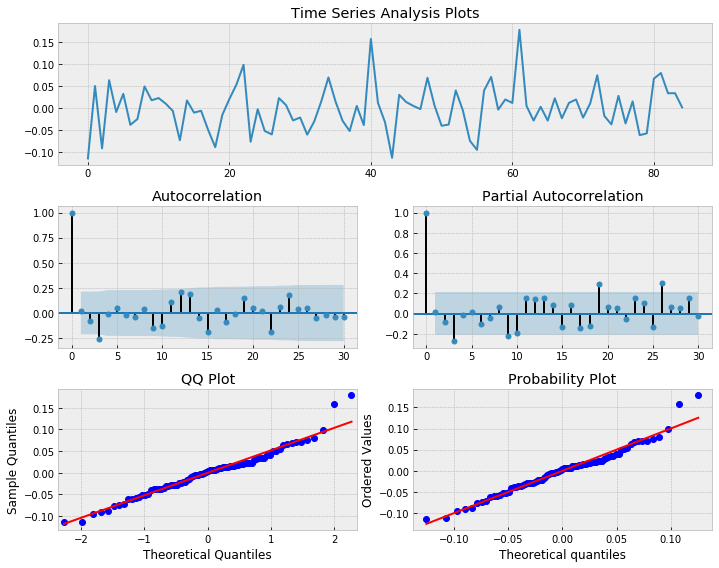

In [256]:
tsplot(res.resid, lags = 30)

## Adding Exogenous Variable 2: Rest Days

In [257]:
d['restdays'] = diffs

#d.columns = ['homeaway', 'scoreresiduals', 'restdays']

lm = smf.ols(formula = 'scores ~ homeaway + restdays', data=d)

res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.4055
Date:                Thu, 23 Aug 2018   Prob (F-statistic):              0.668
Time:                        15:18:51   Log-Likelihood:                -61.221
No. Observations:                  85   AIC:                             128.4
Df Residuals:                      82   BIC:                             135.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5759      0.090      6.423      0.0

In [258]:
amx = arch_model(res.resid**2, vol = 'GARCH', p=1, o = 1, q=1, dist = 'Normal')
res = amx.fit(update_freq = 5)
print(res.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: -130.71999679393073
Iteration:     10,   Func. Count:     83,   Neg. LLF: -130.9114992266071
Iteration:     15,   Func. Count:    118,   Neg. LLF: -130.92510232074324
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -130.92511556352946
            Iterations: 16
            Function evaluations: 125
            Gradient evaluations: 16
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                130.925
Distribution:                  Normal   AIC:                          -251.850
Method:            Maximum Likelihood   BIC:                          -239.637
                                        No. Observations:                   85
Date:        

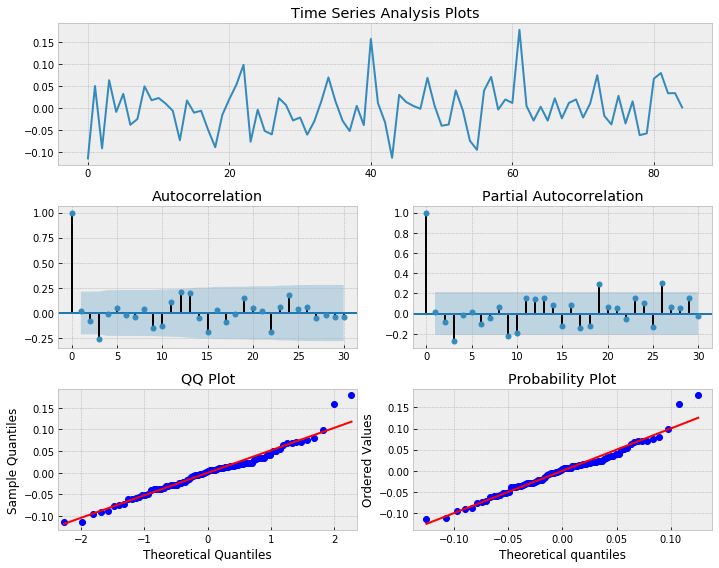

In [259]:
tsplot(res.resid, lags = 30)

# Next Steps

+ High volatility in the player rating data suggests that the player performances is not constant
+ Due to this we need to use non-linear time series modeling 
+ Worth looking at Recurrent Neural Nets/Gaussian Processes/GAMs, Kernel Regression/B-Splines etc.
+ Addition of other exogenous variables (eg. some kind of a opposition team strength rating)


In [260]:
with open('players.pkl', 'rb') as f:
     players_imp = pickle.load(f)

In [261]:
with open ('scores-2.p', 'rb') as fp:
    scores = pickle.load(fp)

In [262]:
newlist = [item for items in list(scores.values()) for item in items]
newlist = sorted(newlist)
mean_score = np.mean(newlist)

In [263]:
median_score = 2 + np.percentile(newlist, 50)
score_75 = 2+ np.percentile(newlist, 75)
score_90 = 2+ np.percentile(newlist, 90)
score_99 = 2 + np.percentile(newlist, 99)

## Scouting Use Cases

+ Identifying Inconsistent Players
+ Identifying Breakout Players Early
+ Identifying Fading Players
+ Reliably Detecting Change in Performance Levels

## Case 1: Inconsistent Player

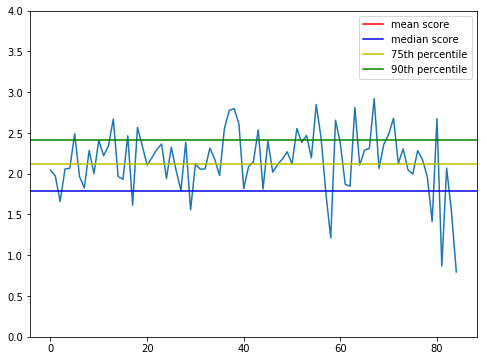

In [264]:
plt.figure(figsize = (8,6))
plt.plot(players_imp[0])
plt.axhline(y=mean_score, color='r', linestyle='-', label = 'mean score')
plt.axhline(y=median_score, color='b', linestyle='-', label = 'median score')
plt.axhline(y=score_75, color='y', linestyle='-', label = '75th percentile')
plt.axhline(y=score_90, color='g', linestyle='-', label = '90th percentile')
plt.legend(loc = 'upper right')
plt.ylim((0,4))
plt.show()

## Case 2: Elite Player On the Way Down?

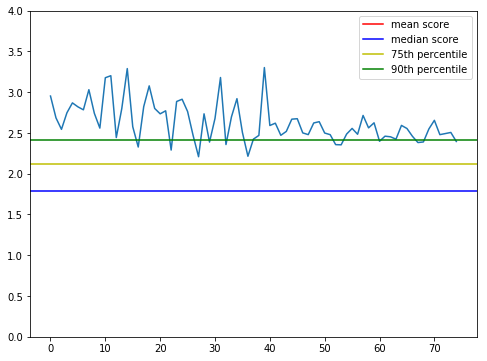

In [265]:
plt.figure(figsize = (8,6))
plt.plot(players_imp[1])
plt.axhline(y=mean_score, color='r', linestyle='-', label = 'mean score')
plt.axhline(y=median_score, color='b', linestyle='-', label = 'median score')
plt.axhline(y=score_75, color='y', linestyle='-', label = '75th percentile')
plt.axhline(y=score_90, color='g', linestyle='-', label = '90th percentile')
#plt.axhline(y=score_99, color='y', linestyle='-', label = '99th percentile')
plt.legend(loc = 'upper right')
plt.ylim((0,4))
plt.show()

## A Future Star?

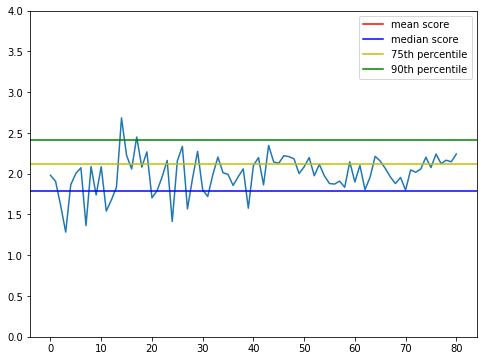

In [266]:
plt.figure(figsize = (8,6))
plt.plot(players_imp[2])
plt.axhline(y=mean_score, color='r', linestyle='-', label = 'mean score')
plt.axhline(y=median_score, color='b', linestyle='-', label = 'median score')
plt.axhline(y=score_75, color='y', linestyle='-', label = '75th percentile')
plt.axhline(y=score_90, color='g', linestyle='-', label = '90th percentile')
plt.legend(loc = 'upper right')
plt.ylim((0,4))
plt.show()

## An Elite Performer

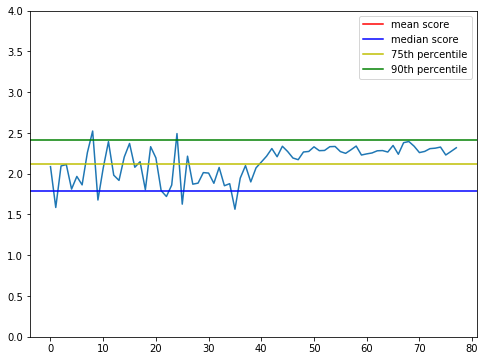

In [267]:
plt.figure(figsize = (8,6))
plt.plot(players_imp[3])
plt.axhline(y=mean_score, color='r', linestyle='-', label = 'mean score')
plt.axhline(y=median_score, color='b', linestyle='-', label = 'median score')
plt.axhline(y=score_75, color='y', linestyle='-', label = '75th percentile')
plt.axhline(y=score_90, color='g', linestyle='-', label = '90th percentile')
plt.legend(loc = 'upper right')
plt.ylim((0,4))
plt.show()

## Player On the Way Down

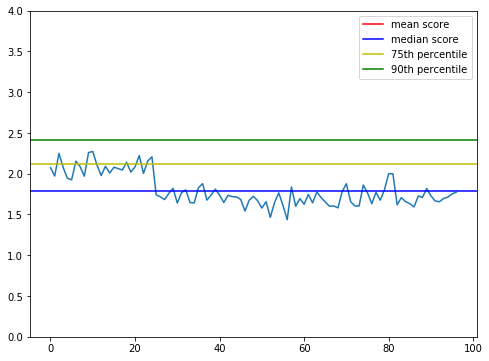

In [268]:
plt.figure(figsize = (8,6))
plt.plot(players_imp[4])
plt.axhline(y=mean_score, color='r', linestyle='-', label = 'mean score')
plt.axhline(y=median_score, color='b', linestyle='-', label = 'median score')
plt.axhline(y=score_75, color='y', linestyle='-', label = '75th percentile')
plt.axhline(y=score_90, color='g', linestyle='-', label = '90th percentile')
#plt.axhline(y=score_99, color='y', linestyle='-', label = '99th percentile')
plt.legend(loc = 'upper right')
plt.ylim((0,4))
plt.show()

## A Solid, Consistent Player

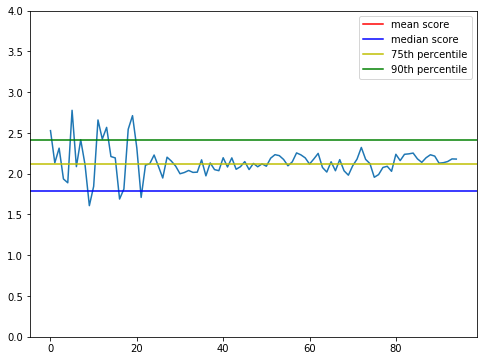

In [269]:
plt.figure(figsize = (8,6))
plt.plot(players_imp[5])
plt.axhline(y=mean_score, color='r', linestyle='-', label = 'mean score')
plt.axhline(y=median_score, color='b', linestyle='-', label = 'median score')
plt.axhline(y=score_75, color='y', linestyle='-', label = '75th percentile')
plt.axhline(y=score_90, color='g', linestyle='-', label = '90th percentile')
plt.legend(loc = 'upper right')
plt.ylim((0,4))
plt.show()

## Exploiting Weak Stationarity Conditions

+ Weak Stationarity for a time series assumes: Constant mean, constant variance, fixed autocorrelation.

+ Can we detect a change in either of these three parameters?

+ Can we detect when this change occured?

+ We can use this information to value players accordingly, as larger samples generalize better , i.e. lower risk -> can be sure of valuation when spending on a player

## Bayesian Changepoint Detection

In [270]:
import pymc3 as pm

$$
\begin{aligned}
M_t &\sim \text{Normal}(m_t, \sigma_t), m_t= \begin{cases}
m1, & \text{if } t \lt s \\ 
m2, & \text{if } t \ge s 
\end{cases} \\ 
s &\sim \text{Unif}(t_l, t_h)\\
m1 &\sim \text{Normal}(1, 0.2)\\
m2 &\sim \text{Normal}(1.2, 0.1)
\end{aligned}
$$

the parameters are defined as follows:
* $M_t$: The mean score for player at time $t$,
* $\sigma_t$: The variance parameter of the Normal distribution of scores around game $t$. 
* $s$: The game in which the mean parameter changes (the switchpoint).
* $m1$: The mean parameter before the switchpoint $s$.
* $m2$: The mean parameter after the switchpoint $s$.
* $t_l$, $t_h$: The lower and upper boundaries of games $t$. 



In [271]:
players_imp[4]

game = np.arange(1, len(players_imp[4])+1)

In [272]:
with pm.Model() as player_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=game.min(), upper=game.max())

    # Priors for pre- and post-switch mean scores
    early_mean = pm.Normal('early_mean', 1., 0.2)
    late_mean = pm.Normal('late_mean', 1.2, 0.2)

    # Allocate appropriate Normal means to games before and after current
    mean = pm.math.switch(switchpoint <= game, early_mean, late_mean)

    scores = pm.Normal('scores', mean, 0.2, observed=players_imp[4])

In [273]:
with player_model:
    step = pm.Slice()
    trace = pm.sample(20000, step = step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [late_mean]
>Slice: [early_mean]
>Slice: [switchpoint]
100%|██████████| 20500/20500 [00:27<00:00, 750.73it/s]


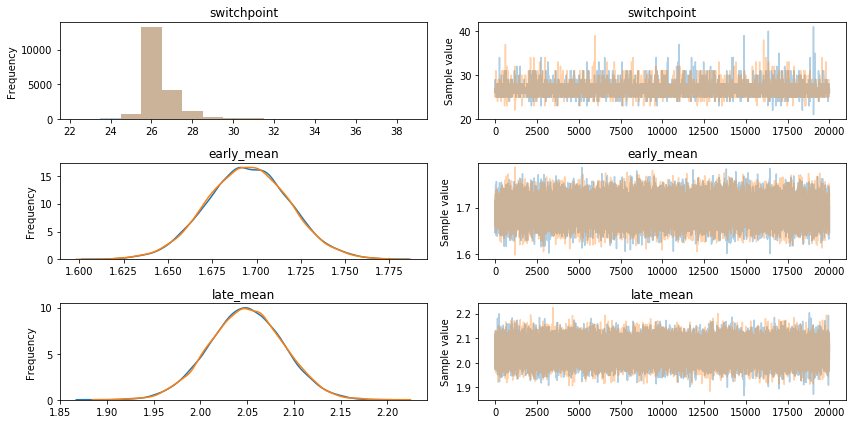

In [274]:
pm.traceplot(trace);

In [275]:
players_imp[2]

game = np.arange(1, len(players_imp[2])+1)

In [276]:
with pm.Model() as player_model2:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=game.min(), upper=game.max())

    # Priors for pre- and post-switch mean scores
    early_mean = pm.Normal('early_mean', 1.8, 0.3)
    late_mean = pm.Normal('late_mean', 1.5, 0.3)

    # Allocate appropriate Normal means to games before and after current
    mean = pm.math.switch(switchpoint <= game, early_mean, late_mean)

    scores = pm.Normal('scores', mean, 0.3, observed=players_imp[2])

In [277]:
with player_model2:
    step = pm.Slice()
    trace = pm.sample(20000, step = step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [late_mean]
>Slice: [early_mean]
>Slice: [switchpoint]
100%|██████████| 20500/20500 [00:25<00:00, 793.17it/s]
The number of effective samples is smaller than 25% for some parameters.


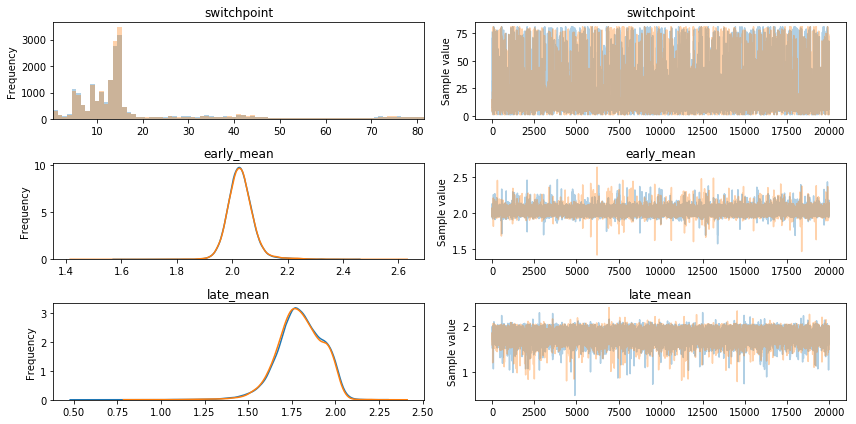

In [278]:
pm.traceplot(trace);

## Thanks!

## Questions?